In [2]:
from mido import MidiFile
from unidecode import unidecode
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

class Read_midi(object):
    def __init__(self, song_path, quantization):
        ## Metadata
        self.__song_path = song_path
        self.__quantization = quantization

        ## Pianoroll
        self.__T_pr = None

        ## Private misc
        self.__num_ticks = None
        self.__T_file = None

    @property
    def quantization(self):
        return self.__quantization

    @property
    def T_pr(self):
        return self.__T_pr

    @property
    def T_file(self):
        return self.__T_file

    def get_total_num_tick(self):
        # Midi length should be written in a meta message at the beginning of the file,
        # but in many cases, lazy motherfuckers didn't write it...

        # Read a midi file and return a dictionnary {track_name : pianoroll}
        mid = MidiFile(self.__song_path)

        # Parse track by track
        num_ticks = 0
        for i, track in enumerate(mid.tracks):
            tick_counter = 0
            for message in track:
                # Note on
                time = float(message.time)
                tick_counter += time
            num_ticks = max(num_ticks, tick_counter)
        self.__num_ticks = num_ticks

    def get_pitch_range(self):
        mid = MidiFile(self.__song_path)
        min_pitch = 200
        max_pitch = 0
        for i, track in enumerate(mid.tracks):
            for message in track:
                if message.type in ['note_on', 'note_off']:
                    pitch = message.note
                    if pitch > max_pitch:
                        max_pitch = pitch
                    if pitch < min_pitch:
                        min_pitch = pitch
        return min_pitch, max_pitch

    def get_time_file(self):
        # Get the time dimension for a pianoroll given a certain quantization
        mid = MidiFile(self.__song_path)
        # Tick per beat
        ticks_per_beat = mid.ticks_per_beat
        # Total number of ticks
        self.get_total_num_tick()
        # Dimensions of the pianoroll for each track
        self.__T_file = int((self.__num_ticks / ticks_per_beat) * self.__quantization)
        return self.__T_file

    def read_file(self):
        # Read the midi file and return a dictionnary {track_name : pianoroll}
        mid = MidiFile(self.__song_path)
        # Tick per beat
        ticks_per_beat = mid.ticks_per_beat

        # Get total time
        self.get_time_file()
        T_pr = self.__T_file
        # Pitch dimension
        N_pr = 128
        pianoroll = {}

        def add_note_to_pr(note_off, notes_on, pr):
            pitch_off, _, time_off = note_off
            # Note off : search for the note in the list of note on,
            # get the start and end time
            # write it in th pr
            match_list = [(ind, item) for (ind, item) in enumerate(notes_on) if item[0] == pitch_off]
            if len(match_list) == 0:
                print("Try to note off a note that has never been turned on")
                # Do nothing
                return

            # Add note to the pr
            pitch, velocity, time_on = match_list[0][1]
            pr[time_on:time_off, pitch] = velocity
            # Remove the note from notes_on
            ind_match = match_list[0][0]
            del notes_on[ind_match]
            return

        # Parse track by track
        counter_unnamed_track = 0
        for i, track in enumerate(mid.tracks):
            # Instanciate the pianoroll
            pr = np.zeros([T_pr, N_pr])
            time_counter = 0
            notes_on = []
            for message in track:

                ##########################################
                ##########################################
                ##########################################
                # TODO : keep track of tempo information
                # import re
                # if re.search("tempo", message.type):
                #     import pdb; pdb.set_trace()
                ##########################################
                ##########################################
                ##########################################


                # print message
                # Time. Must be incremented, whether it is a note on/off or not
                time = float(message.time)
                time_counter += time / ticks_per_beat * self.__quantization
                # Time in pr (mapping)
                time_pr = int(round(time_counter))
                # Note on
                if message.type == 'note_on':
                    # Get pitch
                    pitch = message.note
                    # Get velocity
                    velocity = message.velocity
                    if velocity > 0:
                        notes_on.append((pitch, velocity, time_pr))
                    elif velocity == 0:
                        add_note_to_pr((pitch, velocity, time_pr), notes_on, pr)
                # Note off
                elif message.type == 'note_off':
                    pitch = message.note
                    velocity = message.velocity
                    add_note_to_pr((pitch, velocity, time_pr), notes_on, pr)

            # We deal with discrete values ranged between 0 and 127
            #     -> convert to int
            pr = pr.astype(np.int16)
            if np.sum(np.sum(pr)) > 0:
                name = unidecode(track.name)
                name = name.rstrip('\x00')
                if name == u'':
                    name = 'unnamed' + str(counter_unnamed_track)
                    counter_unnamed_track += 1
                if name in pianoroll.keys():
                    # Take max of the to pianorolls
                    pianoroll[name] = np.maximum(pr, pianoroll[name])
                else:
                    pianoroll[name] = pr
        return pianoroll

In [97]:
def make_pianoroll(midi_data, filename=None, enhance=None):
    data_nan = {}
    if enhance is not None:
        new_midi_data = {}
        new_midi_data[enhance] = midi_data[enhance]
        for (k, v) in midi_data.items():
            if k != enhance:
                new_midi_data[k] = midi_data[k]
        midi_data = new_midi_data
    
    for ii, (k, v) in enumerate(midi_data.items()):
        data_nan[k] = v
        data_nan[k] = np.where(data_nan[k] == 0, 0, data_nan[k])
        data_nan[k] = np.where(data_nan[k] > 0, ii+1, data_nan[k])
        print(ii+1, k, end=' | ')
    print()
        
        
    per_track_pianoroll = np.maximum.reduce(list(data_nan.values()))
    per_track_pianoroll = np.where(per_track_pianoroll == 0, np.nan, per_track_pianoroll)

    fig, ax = plt.subplots(figsize=(13, 3), dpi=600)
    cmap = mpl.colormaps.get_cmap('tab10')
    if enhance is not None:
        cmap = mpl.colors.ListedColormap([(0, 0, 0)] + list(plt.cm.tab10.colors))
    
    im = ax.imshow(per_track_pianoroll.T, cmap=cmap, interpolation="none", origin='lower', aspect='auto')
    # fig.colorbar(im, ticks=range(len(data_nan)))
    ax.set_ylim(30, 127)
    plt.xticks([], [])
    if enhance is None:
        plt.yticks([], [])
    
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    return per_track_pianoroll.T

1 glockenspiel | 2 electric-guitar | 3 electric-bass | 4 strings | 5 flute | 


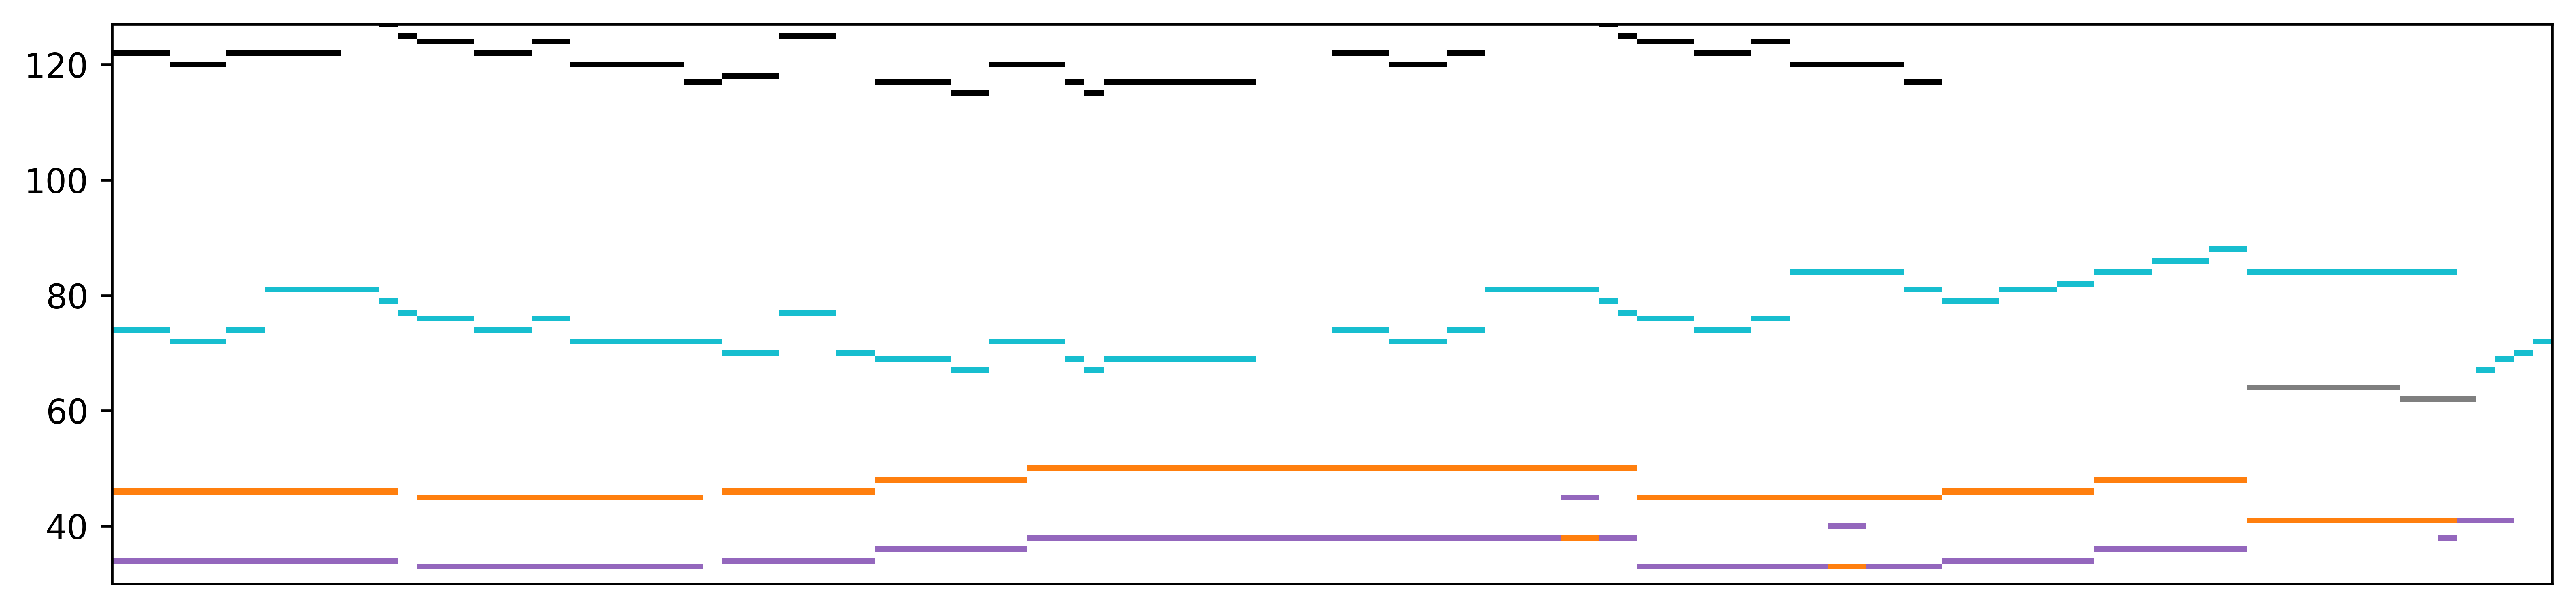

In [98]:
midi_data = Read_midi("audio/pitchclass_impact/orig.mid", 4).read_file()
pr_orch_less = make_pianoroll(midi_data, 'images/pitchclass_impact_orig.png', 'glockenspiel')

1 cello | 2 glockenspiel | 3 electric-guitar | 4 electric-bass | 5 flute | 


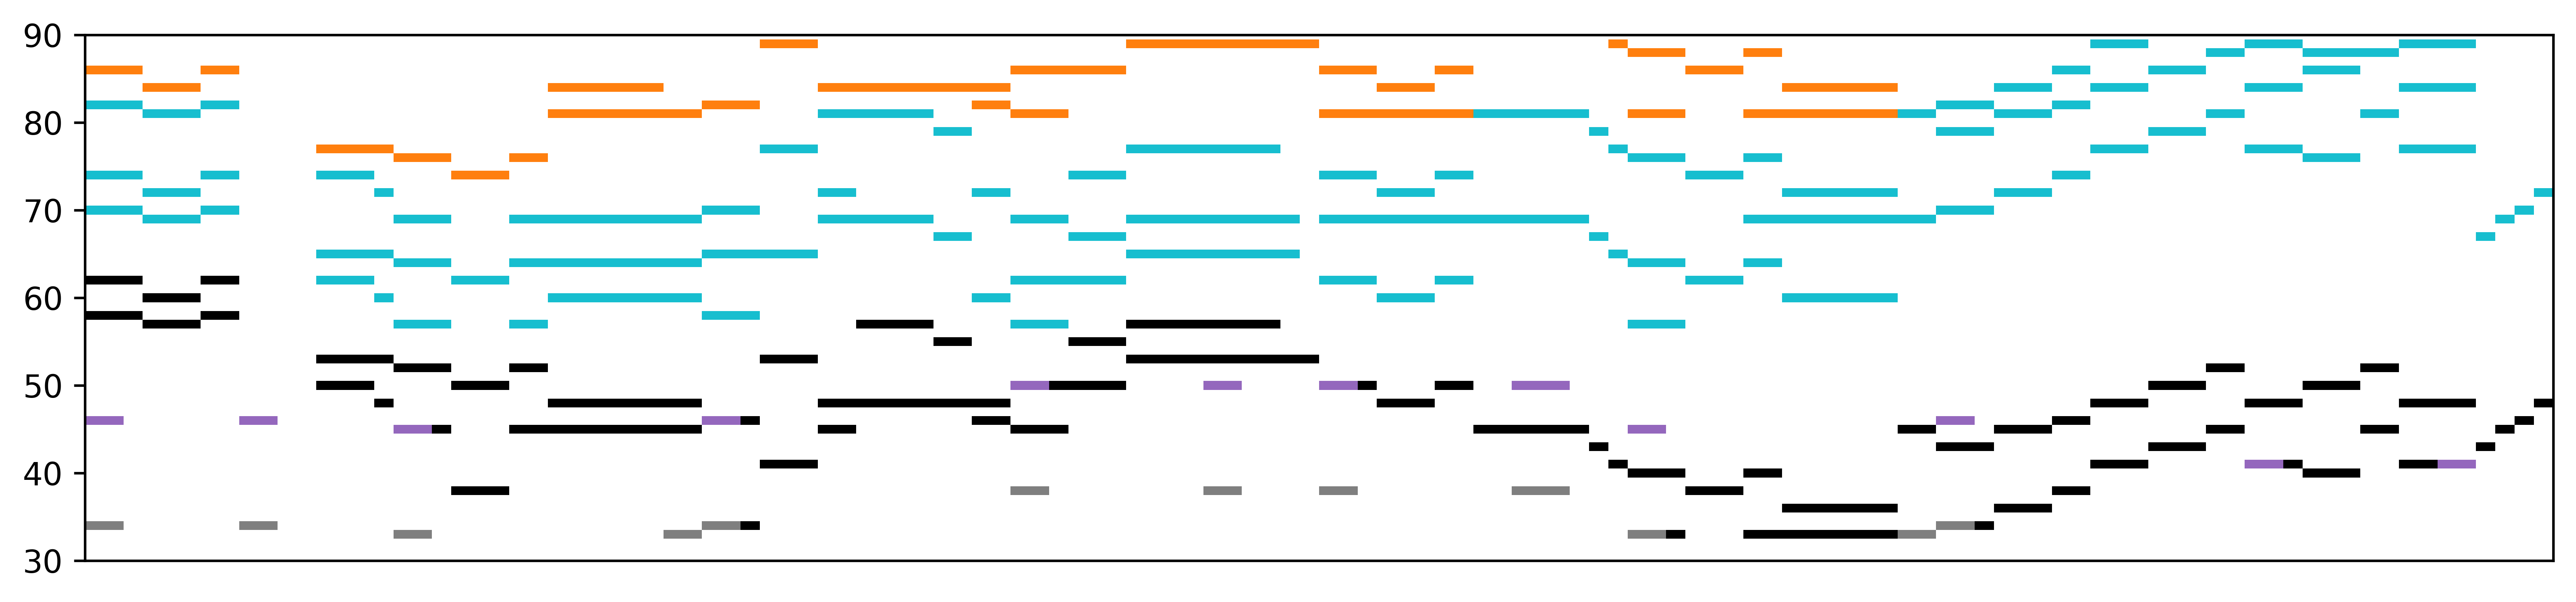

In [93]:
midi_data = Read_midi("audio/pitchclass_impact/mel_cello.mid", 4).read_file()
pr_orch_less = make_pianoroll(midi_data, 'images/pitchclass_impact_mel_cello.png', 'cello')